In [ ]:
! lamin load scprint

In [1]:
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

seed_everything(42, workers=True)

from scprint import scPrint
from scprint.trainer import TrainingMode
from scdataloader import DataModule

import torch 
torch.set_float32_matmul_precision('medium')

%load_ext autoreload
%autoreload 2

Global seed set to 42


💡 lamindb instance: jkobject/scprint


In [2]:
# TODO: drop tissue & dev stage until part or is taken in account

hierarchical_labels = [
    "cell_type_ontology_term_id", #1
    #"tissue_ontology_term_id",
    "disease_ontology_term_id", # 2
    #"development_stage_ontology_term_id",
    "assay_ontology_term_id", #3
    'self_reported_ethnicity_ontology_term_id', #4
]
labels_to_pred = hierarchical_labels+[
    'sex_ontology_term_id', #5
    "organism_ontology_term_id", #6
]
all_labels = labels_to_pred+[
    #'dataset_id',
    #'cell_culture',
    "heat_diff",
    "total_counts",
    "nnz",
    "dpt_group",
]

gene_emb = '../data/temp/embeddings.parquet'
d_model=128

In [3]:
# we might want not to order the genes by expression (or do it?)
# we might want to not introduce zeros and 

In [3]:
datamodule = DataModule(
    collection_name="preprocessed dataset",
    gene_embeddings=gene_emb,
    all_labels=all_labels,
    hierarchical_labels=hierarchical_labels,
    organisms=["NCBITaxon:9606"],
    how="most expr",
    max_len=1000,
    add_zero_genes=100,
    label_to_weight=labels_to_pred,
    label_to_pred=labels_to_pred,
    batch_size=64,
    num_workers=1,
    validation_split=0.1,
    test_split=0.1)
testfiles = datamodule.setup()

won't do any check but we recommend to have your dataset coming from local storage
0.0% are aligned
total dataset size is 106.584138411 Gb
---
dataset contains:
     5567614 cells
     70116 genes
     10 labels
     1 organisms
dataset contains 230 classes to predict

downloading gene names from biomart
['ensembl_gene_id', 'hgnc_symbol', 'gene_biotype', 'entrezgene_id', 'start_position', 'chromosome_name']


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


reduced the size to 0.6722574020195106


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


these files will be considered test datasets:
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


In [4]:
model = scPrint(
    genes = datamodule.genes,
    d_model = d_model,
    nhead = 4,
    d_hid = d_model,
    nlayers = 4,
    layers_cls = [],
    labels = datamodule.labels,
    cls_hierarchy = datamodule.cls_hierarchy,
    dropout= 0.1,
    transformer = "flash",
    precpt_gene_emb = gene_emb,
    gene_pos_enc = datamodule.gene_pos,
    mvc_decoder = "inner product",
    label_decoders = datamodule.decoders,
)

In [ ]:
# create a function to transform an scGPT checkpoint to an scPrint's
# ckpt = torch.load("../../scGPT/save/model_e6.pt")
# scPrint.load_from_checkpoint("../../scGPT/save/model_e6.pt")

In [5]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="scprint_test", save_dir="../data/tensorboard")
wandb_logger.watch(model)

#tlogger = TensorBoardLogger(save_dir="../data/tensorboard")
#tlogger.log_graph(model, i)


Wed Feb 14 15:39:53 2024 ERROR Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jkobject (ml4ig). Use `wandb login --relogin` to force relogin
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
#from lightning.pytorch.profilers import PyTorchProfiler
#pytorch_prof = PyTorchProfiler("../data/tensorboard", emit_nvtx=False, group_by_input_shape=True, record_shapes=True, profile_memory=True, with_stack=True, on_trace_ready=torch.profiler.tensorboard_trace_handler("../data/tensorboard/"),)

In [9]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=-1)
trainingmode = TrainingMode(do_denoise=True, noise=[0.3], do_cce=True, cce_sim=0.5, do_ecs=True, ecs_threshold = 0.3, ecs_scale = 1.0, do_mvc=False, do_adv_cls=False, do_next_tp=False, class_scale = 1.0, mask_ratio=[0.15, 0.3], log_grad=False)

trainer = Trainer(precision=16, profiler="simple", limit_train_batches=10, limit_val_batches=0, check_val_every_n_epoch=200)#, gradient_clip_val=10, max_time={"hours": 3}, limit_train_batches=20000, limit_test_batches=0.03, limit_val_batches=3000,logger=wandb_logger, callbacks=[checkpoint_callback, trainingmode]) #detect_anomaly=True, fast_dev_run=20, overfit_batches=10


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# sanity. should be overfiting.
# trainer = Trainer(precision=16, limit_train_batches=10, limit_val_batches=0, check_val_every_n_epoch=200)

In [10]:
trainer.fit(model, datamodule=datamodule)

these files will be considered test datasets:
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | gene_encoder  | GeneEncoder             | 4.3 M 
1 | expr_encoder  | ContinuousValueEncoder  | 512   
2 | pos_encoder   | PositionalEncoding      | 0     
3 | label_encoder | CategoryValueEncoder    | 1.3 K 
4 | time_encoder  | ContinuousValueEncoder  | 512   
5 | transformer   | FlashTransformerEncoder | 793 K 
6 | expr_decoder  | ExprDecoder             | 67.1 K
7 | cls_decoders  | ModuleDict              | 29.7 K
8 | mvc_decoder   | MVCDecoder              | 99.3 K
----------------------------------------------------------
991 K     Trainable params
4.3 M     Non-trainable params
5.3 M     Total params
21.320    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir="../data/tensorboard"

In [41]:
#wandb_logger.finalize(status="aborted")
torch.cuda.empty_cache()

these files will be considered test datasets
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 13:58:35,879:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3200 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 19.67 GiB total capacity; 1.30 GiB already allocated; 9.19 MiB free; 1.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

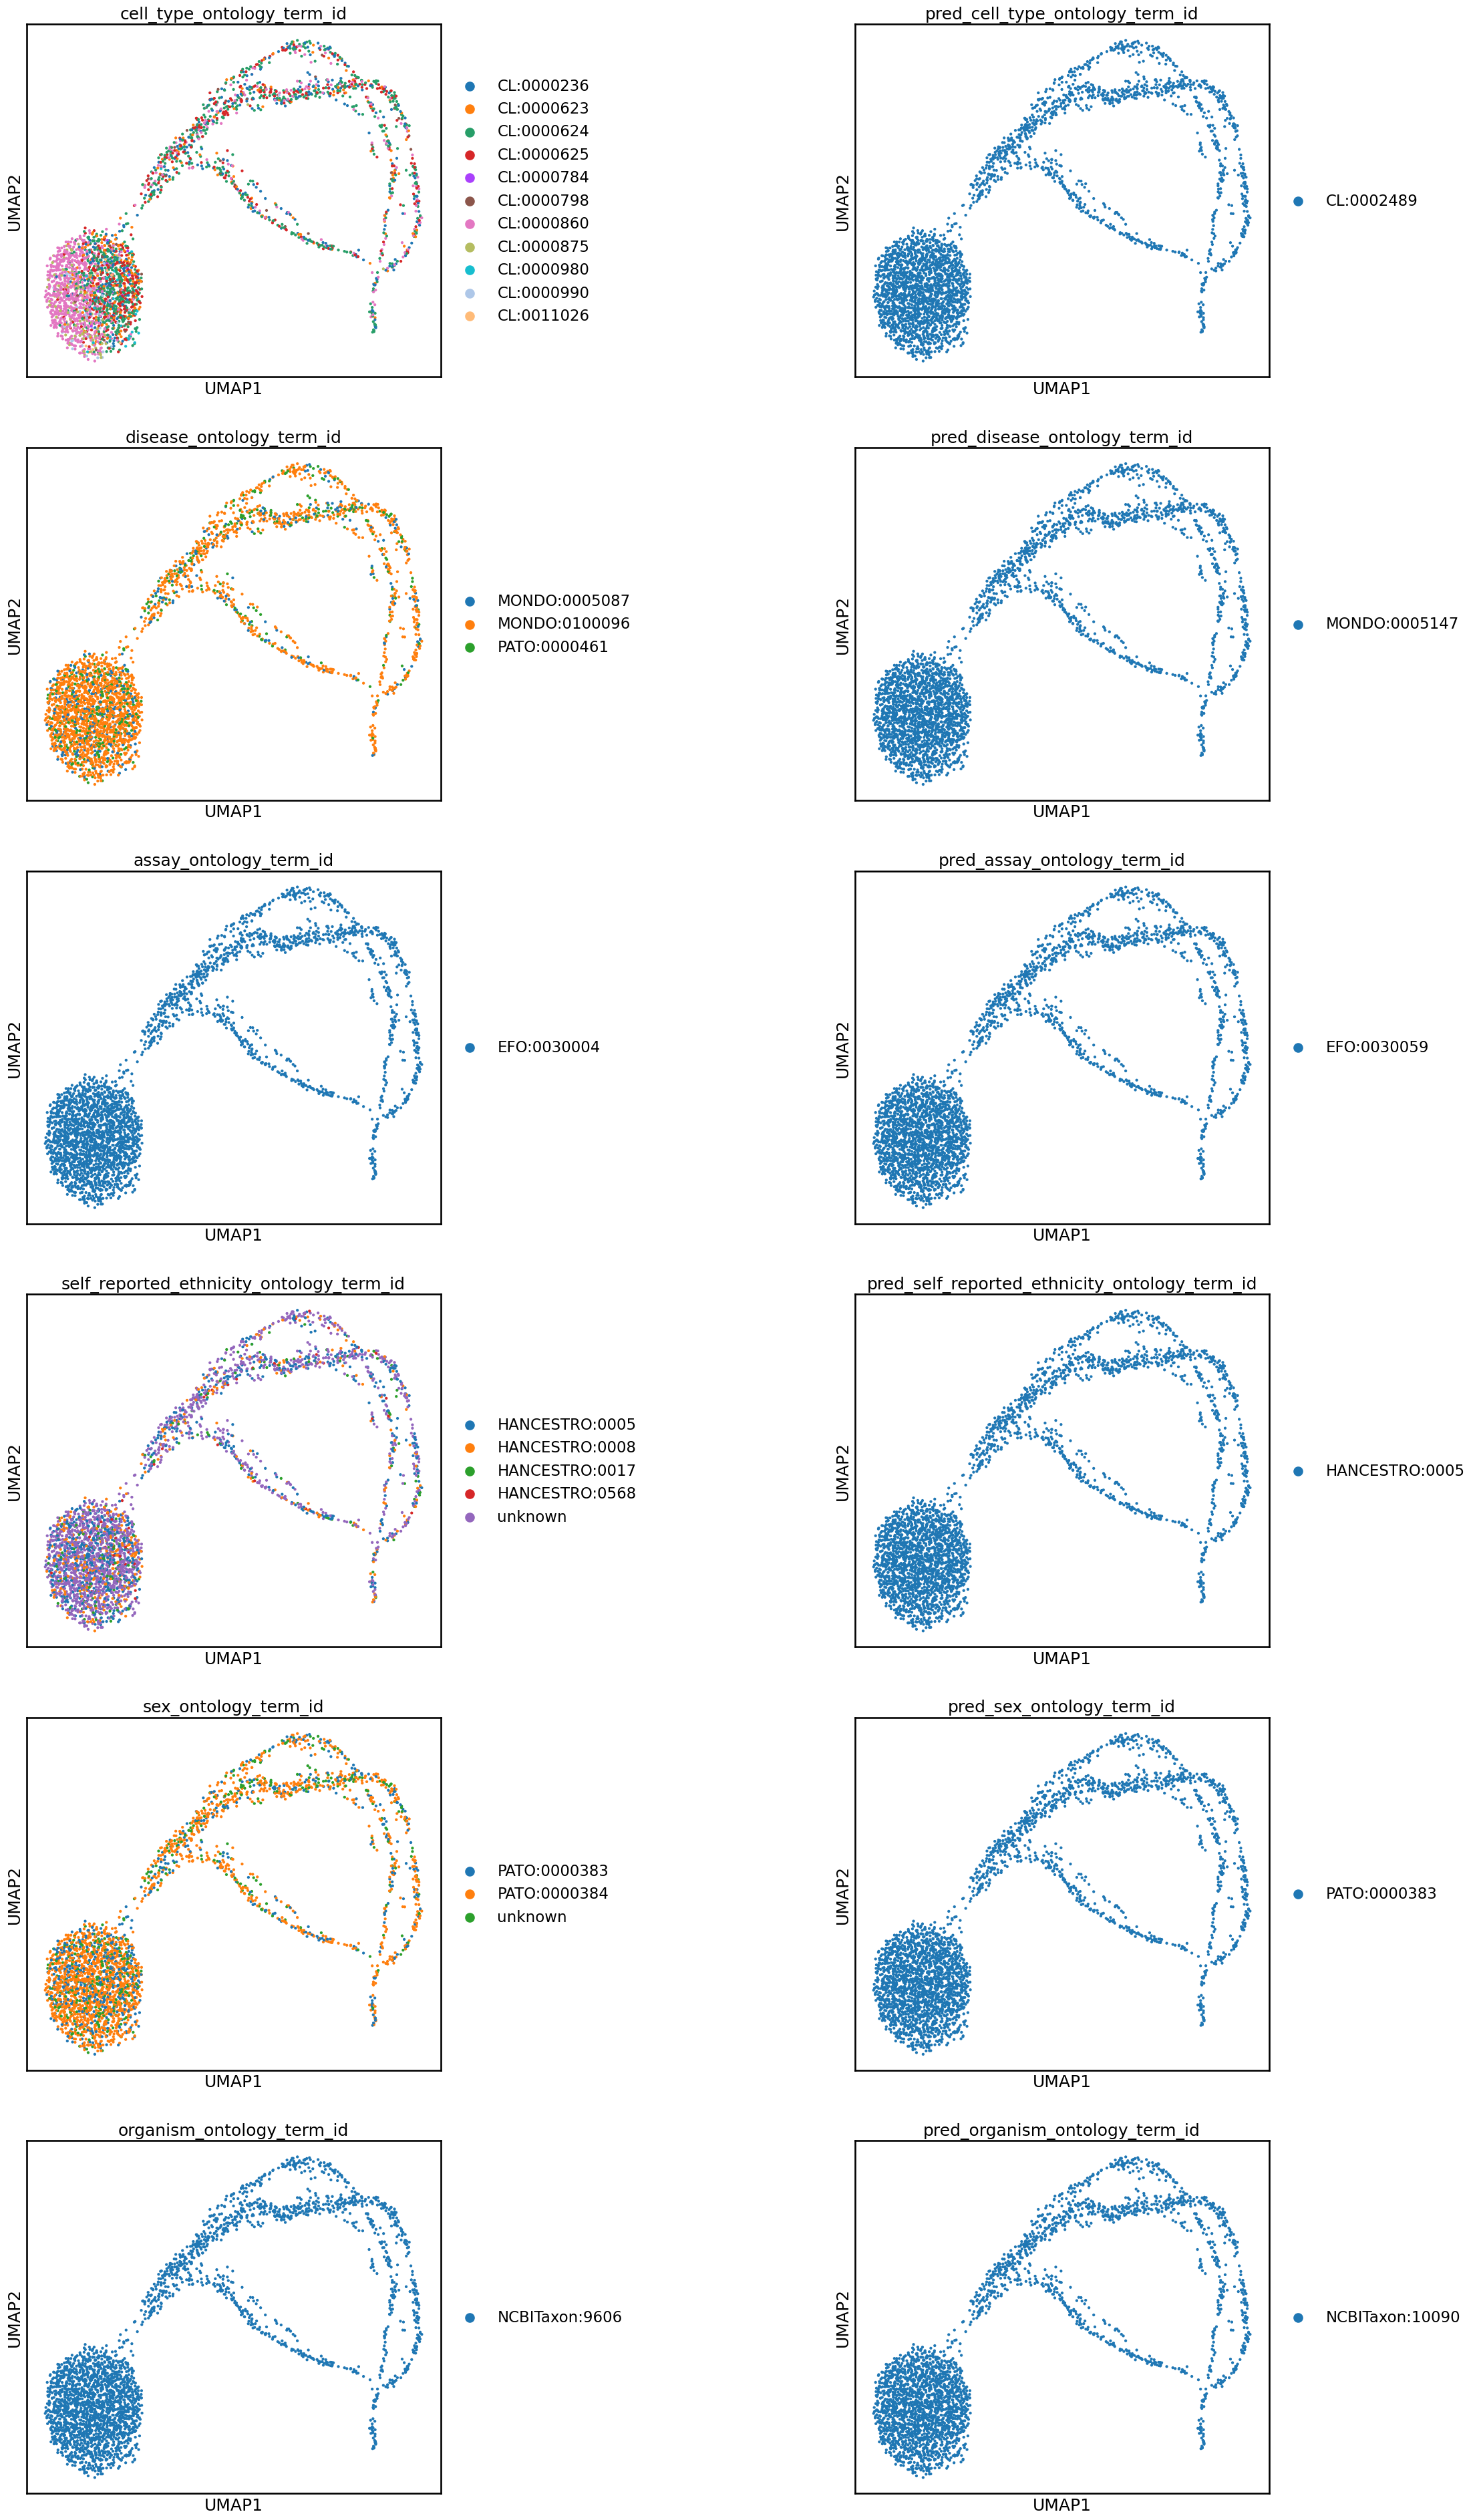

In [40]:
lr_finder = tuner.lr_find(model, datamodule=datamodule)

In [39]:
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
#tuner.scale_batch_size(model, mode="power") #default
lr_finder = tuner.lr_find(model, datamodule=datamodule)

these files will be considered test datasets
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 13:54:48,712:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [37]:
lr_finder

In [32]:
fig = lr_finder.plot(suggest=True)
fig.show()

AttributeError: 'NoneType' object has no attribute 'plot'

In [ ]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
# update hparams of the model
model.hparams.lr = new_lr

In [ ]:
# TODO: debug how much time is spent on class prediction (0.5 day)
# TODO: test unseen genes (do we see much being kept after filtering and stuff) (0.5 day)
# TODO: visualize and assess the embeddings (0.5 day)
----
# TODO: add model checkpointing (0.5 day) 
# TODO: add method to run the model as a script (0.5 day) ---
# TODO: create env and copy data to maestro (0.5 day)
# TODO: create script and test it on maestro (0.5 day)
# TODO: connect with maestro people to ask for longer compute time 
# TODO: do the same to jean zay (0.5 day)
------
# TODO: make a model benchmark package (continue from where I left off) (4 days)
# TODO: make a task function & make a benchmark function (1 day) (*denoising, *classification, *embeddings, *perturbation prediction)
# TODO: define the test set as a subcollection of datasets (print them and save as a file somewhere too) (0.5 day)
------
# TODO: debug the gene embedding creation
# TODO: create embedding & make it work for the 4-5 species in the dataset (1 days) 
# TODO: debug the timepoint problem (2 days)
# TODO: find the neighboors and next time point cells (1 days)
# TODO: create a version with next time point and neighboors task (1 days)
# TODO: make a trajectory prediction task (predict future cell type/s, expression) and benchmark (similarity to known future cell, similarity to known future expression) (1 days)
------
# TODO: log more info with .log() during training (the model architecture) (some weights? some gradients?) (0.5 day)
# TODO: run a large training on maestro (0.5 day)
------
# TODO: add KO & drug datasets
# TODO: create a version with KO and drug effect prediction